In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [2]:
DATA_PATH = '/kaggle/input/dog-breed-identification'
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Подготовка
labels_df = pd.read_csv(f'{DATA_PATH}/labels.csv')
le = LabelEncoder()
labels_df['breed_encoded'] = le.fit_transform(labels_df['breed'])
num_classes = len(le.classes_)

class DogDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['breed_encoded']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [13]:
# Аугментация данных
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# Разделение данных
train_df, val_df = train_test_split(
    labels_df, 
    test_size=0.2, 
    stratify=labels_df['breed'],
    random_state=42
)

train_dataset = DogDataset(
    train_df, 
    img_dir=f'{DATA_PATH}/train', 
    transform=train_transform
)

val_dataset = DogDataset(
    val_df, 
    img_dir=f'{DATA_PATH}/train', 
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2
)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def show_images(loader, 
               class_names=None, 
               mean=[0.485, 0.456, 0.406], 
               std=[0.229, 0.224, 0.225],
               n_images=4,
               figsize=(10, 5)):
    images, labels = next(iter(loader))
    
    images = images[:n_images]
    labels = labels[:n_images]
    
    images = denormalize(images, mean, std)
    
    grid = torchvision.utils.make_grid(images, nrow=min(n_images, 4))
    
    npimg = grid.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    if class_names:
        title = ' | '.join([class_names[label] for label in labels.numpy()])
        plt.title(title, fontsize=14)
    
    plt.axis('off')
    plt.show()

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        
    return tensor

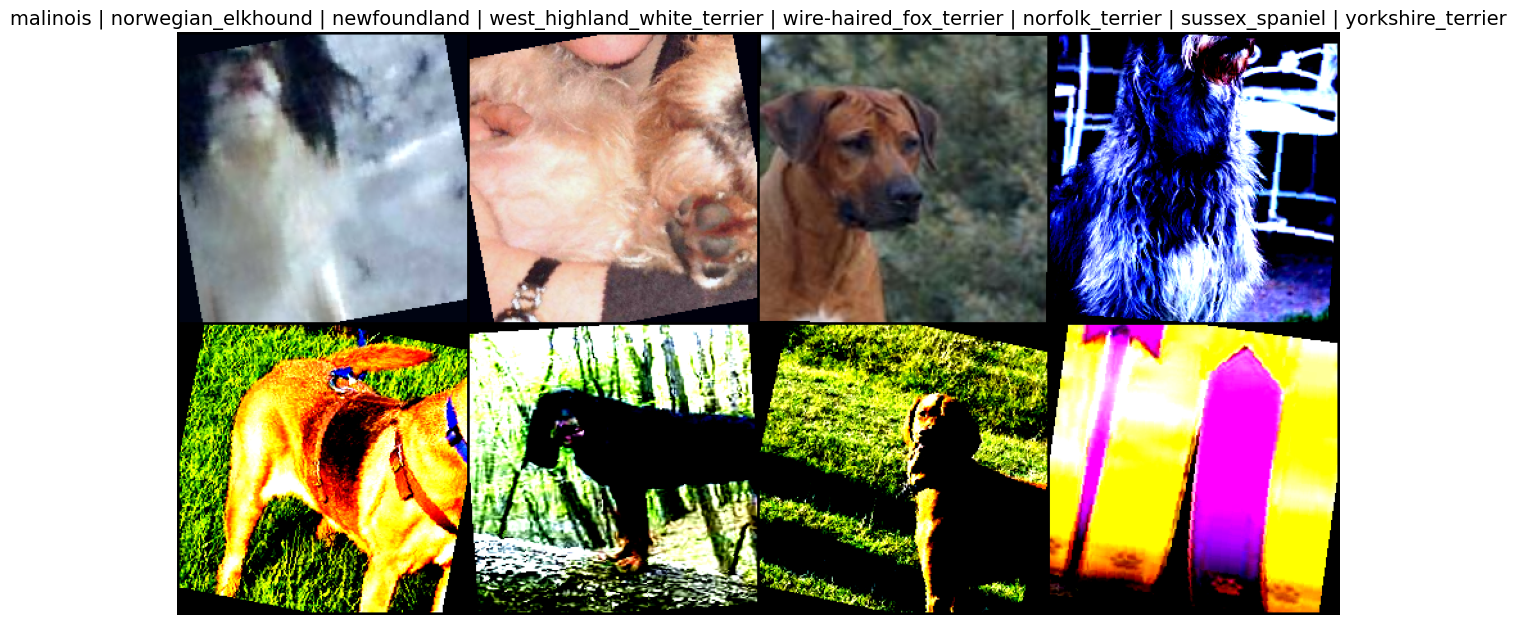

In [16]:
dog_classes = list(labels_df['breed'].unique())

show_images(
    train_loader,
    class_names=dog_classes, 
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    n_images=8,
    figsize=(15, 8)
)

In [17]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Используем EfficientNet в качестве базовой модели
        self.base = models.efficientnet_b0(pretrained=True)
        
        # Замораживаем все слои
        for param in self.base.parameters():
            param.requires_grad = False
            
        # Размораживаем последние 5 слоев
        for param in self.base.features[-5:].parameters():
            param.requires_grad = True
            
        # Удаляем классификатор
        self.base.classifier = nn.Identity()
        
    def forward(self, x):
        return self.base(x)

class DogNet(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_features),
        )

    def forward(self, x):
        return self.model(x)

class DogBreedModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        
        # Получаем размерность выходных признаков
        with torch.no_grad():
            test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
            features = self.feature_extractor(test_input)
            in_features = features.shape[1]
        
        self.classifier = DogNet(in_features, num_classes)
        
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

# Инициализация модели
model = DogBreedModel(num_classes=num_classes).to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=2, 
    factor=0.5,
    verbose=True
)

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in tqdm(loader, desc="Testing", leave=False):
        data, target = data.to(DEVICE), target.to(DEVICE)

        with torch.no_grad():
            output = model(data)
            loss = F.cross_entropy(output, target)

        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()

        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()

        output = model(data)
        loss = F.cross_entropy(output, target)

        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()

        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    best_val_loss = float('inf') 

    for epoch in range(n_epochs):
        # Обучение на одной эпохе
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        
        # Валидация
        val_loss, val_acc = test(model, val_loader)
        
        # Логирование
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        # Расчет средних значений для эпохи
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        
        print(f"\nEpoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        # Сохранение лучшей модели по валидационным потерям
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_loss.pth')
            print(f"Saved best model with val_loss: {val_loss:.4f}")
        
        # Обновление scheduler
        if scheduler:
            scheduler.step(val_loss)  # Оптимизируем по LogLoss
    
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
# Запуск обучения
history = train(
    model, 
    optimizer, 
    EPOCHS, 
    train_loader, 
    val_loader, 
    scheduler=scheduler
)


Epoch 1/100
Train Loss: 3.6056 | Train Acc: 0.1713
Val Loss: 1.8794 | Val Acc: 0.4436
Saved best model with val_loss: 1.8794



Epoch 2/100
Train Loss: 2.3995 | Train Acc: 0.3592
Val Loss: 1.5439 | Val Acc: 0.5487
Saved best model with val_loss: 1.5439



Epoch 3/100
Train Loss: 2.0331 | Train Acc: 0.4416
Val Loss: 1.4084 | Val Acc: 0.5834
Saved best model with val_loss: 1.4084



Epoch 4/100
Train Loss: 1.8310 | Train Acc: 0.4919
Val Loss: 1.3591 | Val Acc: 0.5883
Saved best model with val_loss: 1.3591



Epoch 5/100
Train Loss: 1.5199 | Train Acc: 0.5750
Val Loss: 0.9844 | Val Acc: 0.6806
Saved best model with val_loss: 0.9844



Epoch 6/100
Train Loss: 1.3444 | Train Acc: 0.6219
Val Loss: 0.9770 | Val Acc: 0.6890
Saved best model with val_loss: 0.9770



Epoch 7/100
Train Loss: 1.2777 | Train Acc: 0.6403
Val Loss: 0.9546 | Val Acc: 0.7066
Saved best model with val_loss: 0.9546



Epoch 8/100
Train Loss: 1.1618 | Train Acc: 0.6768
Val Loss: 0.8674 | Val Acc: 0.7330
Saved best model with val_loss: 0.8674



Epoch 9/100
Train Loss: 1.0571 | Train Acc: 0.6967
Val Loss: 0.8795 | Val Acc: 0.7320



Epoch 10/100
Train Loss: 1.0118 | Train Acc: 0.7130
Val Loss: 0.8724 | Val Acc: 0.7374



Epoch 11/100
Train Loss: 0.9605 | Train Acc: 0.7276
Val Loss: 0.8437 | Val Acc: 0.7501
Saved best model with val_loss: 0.8437



Epoch 12/100
Train Loss: 0.9273 | Train Acc: 0.7392
Val Loss: 0.8554 | Val Acc: 0.7428



Epoch 13/100
Train Loss: 0.9066 | Train Acc: 0.7409
Val Loss: 0.8475 | Val Acc: 0.7462



Epoch 14/100
Train Loss: 0.8445 | Train Acc: 0.7625
Val Loss: 0.8273 | Val Acc: 0.7526
Saved best model with val_loss: 0.8273



Epoch 15/100
Train Loss: 0.8685 | Train Acc: 0.7613
Val Loss: 0.8262 | Val Acc: 0.7540
Saved best model with val_loss: 0.8262



Epoch 16/100
Train Loss: 0.8282 | Train Acc: 0.7693
Val Loss: 0.8257 | Val Acc: 0.7569
Saved best model with val_loss: 0.8257



Epoch 17/100
Train Loss: 0.8121 | Train Acc: 0.7714
Val Loss: 0.8215 | Val Acc: 0.7515
Saved best model with val_loss: 0.8215



Epoch 18/100
Train Loss: 0.7978 | Train Acc: 0.7780
Val Loss: 0.8296 | Val Acc: 0.7549



Epoch 19/100
Train Loss: 0.7977 | Train Acc: 0.7791
Val Loss: 0.8196 | Val Acc: 0.7623
Saved best model with val_loss: 0.8196



Epoch 20/100
Train Loss: 0.7868 | Train Acc: 0.7787
Val Loss: 0.8282 | Val Acc: 0.7633



Epoch 21/100
Train Loss: 0.8008 | Train Acc: 0.7732
Val Loss: 0.8224 | Val Acc: 0.7628



Epoch 22/100
Train Loss: 0.7919 | Train Acc: 0.7776
Val Loss: 0.8214 | Val Acc: 0.7613



Epoch 23/100
Train Loss: 0.7909 | Train Acc: 0.7801
Val Loss: 0.8239 | Val Acc: 0.7599



Epoch 24/100
Train Loss: 0.7587 | Train Acc: 0.7889
Val Loss: 0.8214 | Val Acc: 0.7574



Epoch 25/100
Train Loss: 0.7450 | Train Acc: 0.7956
Val Loss: 0.8237 | Val Acc: 0.7588



Epoch 26/100
Train Loss: 0.7527 | Train Acc: 0.7886
Val Loss: 0.8175 | Val Acc: 0.7608
Saved best model with val_loss: 0.8175



Epoch 27/100
Train Loss: 0.7712 | Train Acc: 0.7808
Val Loss: 0.8207 | Val Acc: 0.7614



Epoch 28/100
Train Loss: 0.7757 | Train Acc: 0.7845
Val Loss: 0.8272 | Val Acc: 0.7579



Epoch 29/100
Train Loss: 0.7776 | Train Acc: 0.7806
Val Loss: 0.8216 | Val Acc: 0.7564



Epoch 30/100
Train Loss: 0.7620 | Train Acc: 0.7842
Val Loss: 0.8265 | Val Acc: 0.7604



Epoch 31/100
Train Loss: 0.7623 | Train Acc: 0.7875
Val Loss: 0.8192 | Val Acc: 0.7579



Epoch 32/100
Train Loss: 0.7583 | Train Acc: 0.7877
Val Loss: 0.8259 | Val Acc: 0.7579



Epoch 33/100
Train Loss: 0.7712 | Train Acc: 0.7857
Val Loss: 0.8249 | Val Acc: 0.7555



Epoch 34/100
Train Loss: 0.7427 | Train Acc: 0.7914
Val Loss: 0.8189 | Val Acc: 0.7642



Epoch 35/100
Train Loss: 0.7656 | Train Acc: 0.7844
Val Loss: 0.8234 | Val Acc: 0.7628



Epoch 36/100
Train Loss: 0.7619 | Train Acc: 0.7923
Val Loss: 0.8217 | Val Acc: 0.7589



Epoch 37/100
Train Loss: 0.7732 | Train Acc: 0.7809
Val Loss: 0.8257 | Val Acc: 0.7579



Epoch 38/100
Train Loss: 0.7708 | Train Acc: 0.7866
Val Loss: 0.8256 | Val Acc: 0.7594



Epoch 39/100
Train Loss: 0.7860 | Train Acc: 0.7835
Val Loss: 0.8263 | Val Acc: 0.7579



Epoch 40/100
Train Loss: 0.7901 | Train Acc: 0.7856
Val Loss: 0.8178 | Val Acc: 0.7618



Epoch 41/100
Train Loss: 0.7711 | Train Acc: 0.7843
Val Loss: 0.8218 | Val Acc: 0.7599



Epoch 42/100
Train Loss: 0.7918 | Train Acc: 0.7763
Val Loss: 0.8288 | Val Acc: 0.7614



Epoch 43/100
Train Loss: 0.7542 | Train Acc: 0.7895
Val Loss: 0.8305 | Val Acc: 0.7555



Epoch 44/100
Train Loss: 0.7735 | Train Acc: 0.7850
Val Loss: 0.8208 | Val Acc: 0.7608



Epoch 45/100
Train Loss: 0.7647 | Train Acc: 0.7893
Val Loss: 0.8182 | Val Acc: 0.7613



Epoch 46/100
Train Loss: 0.7547 | Train Acc: 0.7866
Val Loss: 0.8223 | Val Acc: 0.7598



Epoch 47/100
Train Loss: 0.7437 | Train Acc: 0.7900
Val Loss: 0.8237 | Val Acc: 0.7628



Epoch 48/100
Train Loss: 0.7667 | Train Acc: 0.7915
Val Loss: 0.8224 | Val Acc: 0.7594



Epoch 49/100
Train Loss: 0.7597 | Train Acc: 0.7875
Val Loss: 0.8279 | Val Acc: 0.7574



Epoch 50/100
Train Loss: 0.7558 | Train Acc: 0.7902
Val Loss: 0.8241 | Val Acc: 0.7633



Epoch 51/100
Train Loss: 0.7606 | Train Acc: 0.7871
Val Loss: 0.8208 | Val Acc: 0.7608



Epoch 52/100
Train Loss: 0.8076 | Train Acc: 0.7788
Val Loss: 0.8186 | Val Acc: 0.7662



Epoch 53/100
Train Loss: 0.7665 | Train Acc: 0.7880
Val Loss: 0.8246 | Val Acc: 0.7599



Epoch 54/100
Train Loss: 0.7923 | Train Acc: 0.7801
Val Loss: 0.8250 | Val Acc: 0.7603



Epoch 55/100
Train Loss: 0.7574 | Train Acc: 0.7888
Val Loss: 0.8181 | Val Acc: 0.7594



Epoch 56/100
Train Loss: 0.7743 | Train Acc: 0.7802
Val Loss: 0.8162 | Val Acc: 0.7623
Saved best model with val_loss: 0.8162



Epoch 57/100
Train Loss: 0.7933 | Train Acc: 0.7808
Val Loss: 0.8269 | Val Acc: 0.7633



Epoch 58/100
Train Loss: 0.7620 | Train Acc: 0.7892
Val Loss: 0.8148 | Val Acc: 0.7604
Saved best model with val_loss: 0.8148



Epoch 59/100
Train Loss: 0.7460 | Train Acc: 0.7937
Val Loss: 0.8263 | Val Acc: 0.7594



Epoch 60/100
Train Loss: 0.7402 | Train Acc: 0.7916
Val Loss: 0.8163 | Val Acc: 0.7599



Epoch 61/100
Train Loss: 0.7605 | Train Acc: 0.7863
Val Loss: 0.8171 | Val Acc: 0.7589



Epoch 62/100
Train Loss: 0.7668 | Train Acc: 0.7877
Val Loss: 0.8279 | Val Acc: 0.7628



Epoch 63/100
Train Loss: 0.7371 | Train Acc: 0.7921
Val Loss: 0.8257 | Val Acc: 0.7564



Epoch 64/100
Train Loss: 0.7835 | Train Acc: 0.7758
Val Loss: 0.8209 | Val Acc: 0.7623



Epoch 65/100
Train Loss: 0.7464 | Train Acc: 0.7910
Val Loss: 0.8150 | Val Acc: 0.7618



Epoch 66/100
Train Loss: 0.7699 | Train Acc: 0.7860
Val Loss: 0.8238 | Val Acc: 0.7618



Epoch 67/100
Train Loss: 0.7774 | Train Acc: 0.7827
Val Loss: 0.8158 | Val Acc: 0.7598



Epoch 68/100
Train Loss: 0.7568 | Train Acc: 0.7836
Val Loss: 0.8164 | Val Acc: 0.7599



Epoch 69/100
Train Loss: 0.7581 | Train Acc: 0.7892
Val Loss: 0.8163 | Val Acc: 0.7623



Epoch 70/100
Train Loss: 0.7593 | Train Acc: 0.7890
Val Loss: 0.8209 | Val Acc: 0.7623



Epoch 71/100
Train Loss: 0.7869 | Train Acc: 0.7828
Val Loss: 0.8238 | Val Acc: 0.7598



Epoch 72/100
Train Loss: 0.7750 | Train Acc: 0.7880
Val Loss: 0.8223 | Val Acc: 0.7623



Epoch 73/100
Train Loss: 0.7575 | Train Acc: 0.7906
Val Loss: 0.8286 | Val Acc: 0.7589



Epoch 74/100
Train Loss: 0.7796 | Train Acc: 0.7872
Val Loss: 0.8215 | Val Acc: 0.7579



Epoch 75/100
Train Loss: 0.8022 | Train Acc: 0.7780
Val Loss: 0.8243 | Val Acc: 0.7608



Epoch 76/100
Train Loss: 0.7595 | Train Acc: 0.7902
Val Loss: 0.8202 | Val Acc: 0.7609



Epoch 77/100
Train Loss: 0.7431 | Train Acc: 0.7899
Val Loss: 0.8190 | Val Acc: 0.7613



Epoch 78/100
Train Loss: 0.7333 | Train Acc: 0.7945
Val Loss: 0.8201 | Val Acc: 0.7628



Epoch 79/100
Train Loss: 0.7663 | Train Acc: 0.7874
Val Loss: 0.8189 | Val Acc: 0.7579



Epoch 80/100
Train Loss: 0.7551 | Train Acc: 0.7870
Val Loss: 0.8286 | Val Acc: 0.7589



Epoch 81/100
Train Loss: 0.7686 | Train Acc: 0.7845
Val Loss: 0.8206 | Val Acc: 0.7609



Epoch 82/100
Train Loss: 0.7581 | Train Acc: 0.7900
Val Loss: 0.8141 | Val Acc: 0.7614
Saved best model with val_loss: 0.8141



Epoch 83/100
Train Loss: 0.7833 | Train Acc: 0.7818
Val Loss: 0.8230 | Val Acc: 0.7579



Epoch 84/100
Train Loss: 0.7665 | Train Acc: 0.7889
Val Loss: 0.8278 | Val Acc: 0.7599



Epoch 85/100
Train Loss: 0.7545 | Train Acc: 0.7895
Val Loss: 0.8246 | Val Acc: 0.7604



Epoch 86/100
Train Loss: 0.7631 | Train Acc: 0.7881
Val Loss: 0.8259 | Val Acc: 0.7598



Epoch 87/100
Train Loss: 0.7466 | Train Acc: 0.7906
Val Loss: 0.8203 | Val Acc: 0.7574



Epoch 88/100
Train Loss: 0.7869 | Train Acc: 0.7771
Val Loss: 0.8207 | Val Acc: 0.7594



Epoch 89/100
Train Loss: 0.7508 | Train Acc: 0.7901
Val Loss: 0.8131 | Val Acc: 0.7628
Saved best model with val_loss: 0.8131



Epoch 90/100
Train Loss: 0.7710 | Train Acc: 0.7868
Val Loss: 0.8205 | Val Acc: 0.7613



Epoch 91/100
Train Loss: 0.7803 | Train Acc: 0.7850
Val Loss: 0.8195 | Val Acc: 0.7633



Epoch 92/100
Train Loss: 0.7331 | Train Acc: 0.7962
Val Loss: 0.8191 | Val Acc: 0.7608



Epoch 93/100
Train Loss: 0.7720 | Train Acc: 0.7855
Val Loss: 0.8254 | Val Acc: 0.7628



Epoch 94/100
Train Loss: 0.7662 | Train Acc: 0.7914
Val Loss: 0.8203 | Val Acc: 0.7677



Epoch 95/100
Train Loss: 0.7672 | Train Acc: 0.7886
Val Loss: 0.8186 | Val Acc: 0.7579



Epoch 96/100
Train Loss: 0.7514 | Train Acc: 0.7863
Val Loss: 0.8279 | Val Acc: 0.7618



Epoch 97/100
Train Loss: 0.7772 | Train Acc: 0.7839
Val Loss: 0.8221 | Val Acc: 0.7599



Epoch 98/100
Train Loss: 0.7485 | Train Acc: 0.7908
Val Loss: 0.8283 | Val Acc: 0.7613



Epoch 99/100
Train Loss: 0.7625 | Train Acc: 0.7868
Val Loss: 0.8217 | Val Acc: 0.7574



Epoch 100/100
Train Loss: 0.7585 | Train Acc: 0.7878
Val Loss: 0.8221 | Val Acc: 0.7594


In [20]:
# Создание предсказаний для submission
def create_submission(model, test_dir, transform, device, breed_names):
    test_files = os.listdir(test_dir)
    model.load_state_dict(torch.load('best_model_loss.pth'))
    model.eval()
    
    all_preds = []
    test_ids = []
    
    for file in tqdm(test_files, desc="Processing Test Images"):
        img_path = os.path.join(test_dir, file)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            probas = F.softmax(output, dim=1).cpu().numpy()[0]
        
        all_preds.append(probas)
        test_ids.append(file.split('.')[0])
    
    submission = pd.DataFrame(
        np.vstack(all_preds),
        columns=breed_names
    )
    submission.insert(0, 'id', test_ids)
    return submission

# Генерация submission файла
test_dir = f'{DATA_PATH}/test'
breed_names = le.classes_
submission = create_submission(model, test_dir, val_transform, DEVICE, breed_names)
submission.to_csv('submission.csv', index=False)
print('Submission file created!')


Processing Test Images: 100%|██████████| 10357/10357 [02:27<00:00, 70.08it/s]


Submission file created!
